# Trendsetter Challenge
Use this [dataset](https://snap.stanford.edu/data/loc-gowalla.html) to answer the following

## Definitions
- Assume a “trendsetter” is someone who, in this dataset, visits some of the same
locations as another person, before the other person goes to that location.
- A “trendsetter score” for a person is the number of distinct locations and people that
have visited a location after the "trendsetter".
- A "radius of influence" for a trendsetter is an approximate measurement of the radius of
the circle that bounds the places that person has checked in. Assume the earth is flat.

## Deliverables
1. Two tables containing ten rows including the following information:
- user_id of the trendsetter
- Trendsetter score
- Radius of influence
2. First table displays trendsetters ranked by score, highest to lowest
3. Second table displays trendsetters ranked by radius of influence, highest to lowest

## Rules
- You can use any tools you want to solve this puzzle, except asking for help from other
people. Please feel free to email at any time for any clarifications.
- Provide source code written to come to your conclusion
- If you choose to use an imperative programming language, we give points for "pure"
solutions, so no additional libraries. The more complex the additional libraries, the more
points we deduct.
- We also give points for quality code (or deduct for poor quality). Deliberate formatting
and well constructed, clear and scalable algorithms are important to us.

## Task Decomposition

1. Upload data
2. Make clean up and EDA
3. Calculate a “trendsetter score”
4. Calculate a "radius of influence"
5. Make QA
6. Make Conclusions & Write Report

## 1. Upload Data

In [1]:
# import libraries
import pandas as pd
import numpy as np
from datetime import timedelta
from matplotlib import pyplot as plt
import time
from concurrent.futures import ThreadPoolExecutor
from geopy.distance import geodesic
import folium

In [2]:
# upload friends data
friendship_df = (pd.read_csv('loc-gowalla_edges.txt', 
                            sep = "\t", 
                            header=None, 
                            names=['user_id', 'users_friend_id'])
                )

In [3]:
friendship_df.head()

,user_id,users_friend_id
0,0,1
1,0,2
2,0,3
3,0,4
4,0,5


In [4]:
friendship_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1900654 entries, 0 to 1900653
Data columns (total 2 columns):
 #   Column           Dtype
---  ------           -----
 0   user_id          int64
 1   users_friend_id  int64
dtypes: int64(2)
memory usage: 29.0 MB


In [5]:
# upload check-ins data
checkins_df = (pd.read_csv('loc-gowalla_totalCheckins.txt', 
                          sep = "\t", 
                          header=None, 
                          names=['user_id', 'check_in_time', 'latitude', 'longitude', 'location_id'])
              )

In [6]:
checkins_df.head()

,user_id,check_in_time,latitude,longitude,location_id
0,0,2010-10-19T23:55:27Z,30.235909,-97.795140,22847
1,0,2010-10-18T22:17:43Z,30.269103,-97.749395,420315
2,0,2010-10-17T23:42:03Z,30.255731,-97.763386,316637
3,0,2010-10-17T19:26:05Z,30.263418,-97.757597,16516
4,0,2010-10-16T18:50:42Z,30.274292,-97.740523,5535878


In [7]:
checkins_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6442892 entries, 0 to 6442891
Data columns (total 5 columns):
 #   Column         Dtype  
---  ------         -----  
 0   user_id        int64  
 1   check_in_time  object 
 2   latitude       float64
 3   longitude      float64
 4   location_id    int64  
dtypes: float64(2), int64(2), object(1)
memory usage: 245.8+ MB


## STAGE 1. CONCLUSIONS:
- sucsessfully uploaded data
- observed data types and structure

## 2. Make clean up and EDA

#### 2.1. Friendship dataframa clean up

In [8]:
friendship_df.head()

,user_id,users_friend_id
0,0,1
1,0,2
2,0,3
3,0,4
4,0,5


In [9]:
# how many unique users do we have?
len(friendship_df['user_id'].unique())

196591

In [10]:
# calculate number of friens for each user
influencers = (friendship_df
                    .groupby('user_id')
                    .agg({'users_friend_id':'nunique'})
                    .reset_index()
                    .rename(columns = {"users_friend_id":"friends_count"})
                    .sort_values(by = 'friends_count', ascending = False)
              )

In [11]:
# evaluate the distribution in terms of percentiles
perc = [95, 99, 99.9, 99.99]

for i in perc:
    print(f'{i} percentile is equal:', round(np.percentile(influencers['friends_count'], i)), 'friends')

95 percentile is equal: 34 friends
99 percentile is equal: 94 friends
99.9 percentile is equal: 336 friends
99.99 percentile is equal: 1289 friends


In [12]:
# create a dataframe with top trendsetters
list_of_influencers_df = influencers[influencers['friends_count'] >= np.percentile(influencers['friends_count'], 99.9)]
list_of_influencers_df.shape

(197, 2)

In [13]:
list_of_influencers = list(list_of_influencers_df['user_id'])
len(list_of_influencers)

197

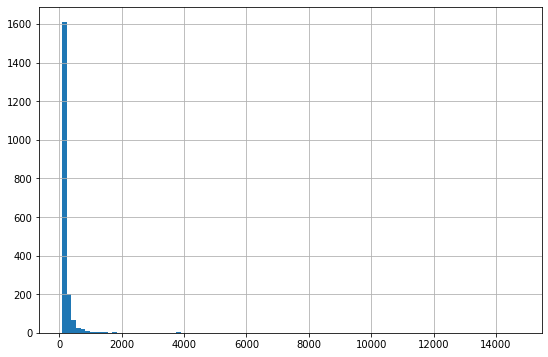

In [14]:
# make a plot with distrubution of friends among top trendsetters
plt.figure(figsize = (9,6))
influencers[influencers['friends_count'] >= np.percentile(influencers['friends_count'], 99)]['friends_count'].hist(bins = 100)
plt.show()

#### 2.2. Check-ins DF

In [15]:
# transform check-in data from object to datetime, also add some additional columns
checkins_df['check_in_time'] = pd.to_datetime(checkins_df['check_in_time'])

In [16]:
checkins_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6442892 entries, 0 to 6442891
Data columns (total 5 columns):
 #   Column         Dtype              
---  ------         -----              
 0   user_id        int64              
 1   check_in_time  datetime64[ns, UTC]
 2   latitude       float64            
 3   longitude      float64            
 4   location_id    int64              
dtypes: datetime64[ns, UTC](1), float64(2), int64(2)
memory usage: 245.8 MB


In [17]:
checkins_df.head()

,user_id,check_in_time,latitude,longitude,location_id
0,0,2010-10-19 23:55:27+00:00,30.235909,-97.795140,22847
1,0,2010-10-18 22:17:43+00:00,30.269103,-97.749395,420315
2,0,2010-10-17 23:42:03+00:00,30.255731,-97.763386,316637
3,0,2010-10-17 19:26:05+00:00,30.263418,-97.757597,16516
4,0,2010-10-16 18:50:42+00:00,30.274292,-97.740523,5535878


In [18]:
# check min & max date
min(checkins_df['check_in_time']), max(checkins_df['check_in_time'])

(Timestamp('2009-02-04 05:17:38+0000', tz='UTC'),
 Timestamp('2010-10-23 05:22:06+0000', tz='UTC'))

In [19]:
# calculate number of check ins for each user and check if there are user with no check ins
users_checkins = (checkins_df
                    .groupby('user_id')
                    .agg({"location_id":"count"})
                    .rename(columns = {"location_id":"count_checkins"})
                    .reset_index()
                 )

users_checkins.head()                                                                                    

,user_id,count_checkins
0,0,225
1,1,12
2,2,2100
3,4,225
4,5,50


In [20]:
# compare user with friends and no check ins
users_with_no_check_ins = influencers.merge(users_checkins, how = 'left', on = 'user_id').fillna(0)
users_with_no_check_ins.query("count_checkins == 0").shape

(89499, 3)

In [21]:
users_with_no_check_ins.query("count_checkins == 0").head(10)

,user_id,friends_count,count_checkins
2,505,5420,0.0
8,207,1953,0.0
13,3,1539,0.0
23,1413,1165,0.0
37,1840,858,0.0
43,2215,817,0.0
44,4336,807,0.0
45,4052,803,0.0
57,409,719,0.0
68,5849,645,0.0


In [22]:
# create a list with such users
exclusion_list = users_with_no_check_ins.query("count_checkins == 0")['user_id'].to_list()
len(exclusion_list)

89499

## STAGE 2. CONCLUSIONS:

During EDA we checked both dataframe and found out that:
- string type for a date column and changed type for a check_in_time column from string to datetime 
- 95% percentile for users with friends is equal 35 friend
- there are users with friends and no check ins
- period of check ins between 2009-02-04 and 2010-10-23

Therefore I have Questions which have been arised after task review and my assumptions:

**Q: What defines a user as a trendsetter?**
A: My assumption is that a user can be considered a trendsetter if they have a larger number of friends. We can set a threshold of 99% percentile to select users who might be trendsetters.

**Q: What is the time window to determine if a user checked in after a specific trendsetter?**
A: My assumption is that friends need some time to follow a trendsetter after a check-in. Therefore, we should establish a suitable time range within which we measure the trendsetter's impact on their friends, for example 48h

**Q: Does it matter if the user who checked in is a friend of the influencer?**
A: I assume that users can only see check-ins of their friends.

**Q: Are there any specific locations to exclude from the check-ins analysis?**
A: I would recommend considering this point because some places may be popular without the promotion of a trendsetter.

**Q: Are there any requirements regarding seasonality? Should we analyze the entire available period or specific time periods (e.g., one full year)?**
A: For the initial analysis, I suggest considering the entire time period. If necessary, we can later break it down into smaller time periods for a more detailed assessment.

**Q: Over 45% users do not have check ins data, should we eliminate them during calculation scores? What should we do with users who have many friends but do now make check ins?**
A: First of all it is better to understand possibiblities of the app: if it is normal case then OK, but now these users would be eliminated from the calculation

## 3. Calculate Trendsetter Score

In [23]:
# Create an empty DataFrame to store the results
results_df = pd.DataFrame(columns=['User ID', 'Trendsetter Score'])

def calculate_trendsetter_score(user_id, exclusion_list, time_window_hours=48):
    if user_id in exclusion_list:
        return 0

    user_checkins = checkins_df[checkins_df['user_id'] == user_id]
    if user_checkins.empty:
        return 0

    # Friends of the user (excluding excluded)
    friends = friendship_df[
        (friendship_df['user_id'] == user_id) & (~friendship_df['users_friend_id'].isin(exclusion_list))
    ]['users_friend_id'].unique()

    influenced_pairs = set()  # store distinct (friend, location)

    # For each check-in of the user
    for _, u_row in user_checkins.iterrows():
        loc = u_row['location_id']
        t_user = u_row['check_in_time']
        t_window_end = t_user + timedelta(hours=time_window_hours)

        # For each friend
        for friend_id in friends:
            friend_checkins = checkins_df[
                (checkins_df['user_id'] == friend_id) & (checkins_df['location_id'] == loc)
            ]

            if not friend_checkins.empty:
                # Friend checks in AFTER user but within window
                if ((friend_checkins['check_in_time'] > t_user) &
                    (friend_checkins['check_in_time'] <= t_window_end)).any():
                    influenced_pairs.add((friend_id, loc))

    score = len(influenced_pairs)

    # Append to results
    results_df.loc[len(results_df)] = [user_id, score]
    return score


In [24]:
# # Create an empty DataFrame to store the results
# results_df = pd.DataFrame(columns=['User ID', 'Trendsetter Score'])

# def calculate_trendsetter_score_v8(user_id, exclusion_list):
#     if user_id in exclusion_list:
#         return 0

#     user_checkins = checkins_df[checkins_df['user_id'] == user_id].copy()
#     if user_checkins.empty:
#         return 0

#     time_window_start = user_checkins['check_in_time'].min()
#     time_window_end = time_window_start + timedelta(hours=48)

#     user_checkins.loc[:, 'time_window_start'] = time_window_start
#     user_checkins.loc[:, 'time_window_end'] = time_window_end

#     friends_data = friendship_df[
#         (friendship_df['user_id'] == user_id) & (~friendship_df['users_friend_id'].isin(exclusion_list))
#     ]

#     trendsetter_score = 0

#     def calculate_friend_trendsetter_score(friend_id):
#         friend_checkins = checkins_df[checkins_df['user_id'] == friend_id]

#         # Merge the friend_checkins with user_checkins based on 'location_id'
#         friend_location_checkins = pd.merge(
#             friend_checkins,
#             user_checkins[['location_id', 'time_window_start', 'time_window_end']],
#             on='location_id'
#         )

#         # Apply boolean indexing to filter based on the time window
#         friend_location_checkins = friend_location_checkins[
#             (friend_location_checkins['check_in_time'] >= friend_location_checkins['time_window_start']) &
#             (friend_location_checkins['check_in_time'] <= friend_location_checkins['time_window_end'])
#         ]

#         return len(user_checkins['location_id'].isin(friend_location_checkins['location_id']))

#     with ThreadPoolExecutor(max_workers=10) as executor:
#         trendsetter_scores = list(executor.map(calculate_friend_trendsetter_score, friends_data['users_friend_id']))

#     trendsetter_score = sum(trendsetter_scores)

#     # Append the result to the results_df
#     results_df.loc[len(results_df)] = [user_id, trendsetter_score]

In [ ]:
# Process the users
for user_id in list_of_influencers:
    trendsetter_score = calculate_trendsetter_score(user_id, exclusion_list)

In [ ]:
results_df.info()

In [ ]:
# final data frame with trendsetter scores
df_final_one = results_df.sort_values(by = 'Trendsetter Score', ascending = False).head(10)
df_final_one

## STAGE 3. CONCLUSIONS:
We made a function in order to calculate a "Trendsetter Score" for a given user based on their check-in data and their friends' check-in data within a specified time window.

**Short function's description:**

1. This function computes a "Trendsetter Score" for a given user, taking into account their check-ins and those of their friends. It does the following:

2. Checks if the user is in an exclusion list and returns a score of 0 if they are.

3. Retrieves the user's check-ins and establishes a time window of 48 hours based on their earliest check-in.

4. Gathers data on the user's friends who are not in the exclusion list.

5. Calculates the Trendsetter Score for the user by examining their friends' check-ins within the user's defined time window. The score is based on the number of locations where the user and their friends have both checked in during that time frame.


## 4. Calculate Radius of Influence


In [ ]:
from itertools import combinations
from geopy.distance import geodesic

# Step 1: Get all user check-in coordinates
user_checkins = checkins_df.groupby('user_id')[['latitude', 'longitude']].agg(lambda x: list(zip(x, x.index))).reset_index()

# Step 2: Replace with your influencer list
users_list = list_of_influencers.copy()
influence_data = []

# Step 3: Correct Radius of Influence (based only on user's own check-ins)
def calculate_radius_of_influence(user_id, checkins_df):
    # Get all distinct locations visited by the user
    locs = checkins_df[checkins_df['user_id'] == user_id][['latitude', 'longitude']].drop_duplicates().values
    
    if len(locs) < 2:
        return 0.0
    
    # Max pairwise distance among user’s own check-ins
    max_dist = max(
        geodesic(p1, p2).meters
        for p1, p2 in combinations(locs, 2)
    )
    
    # Radius = half of diameter
    return max_dist / 2

for user_id in users_list:
    if user_id in exclusion_list:
        continue
    
    influence_radius = calculate_radius_of_influence(user_id, checkins_df)
    influence_data.append({
        'user_id': user_id,
        'radius_of_influence_meters': influence_radius,
        'radius_of_influence_kilometers': round(influence_radius / 1000)  # rounded to nearest km
    })

# Step 4: Build results DataFrame
influence_df = pd.DataFrame(influence_data).sort_values(by='radius_of_influence_kilometers', ascending=False)
influence_df.head(10)


In [ ]:
# # Step 1: Calculate User Influence
# user_checkins = checkins_df.groupby('user_id')[['latitude', 'longitude']].agg(lambda x: x.tolist()).reset_index()

# # Step 2: Replace 'list_of_influencers[:10]' with your actual list of influencers
# users_list = list_of_influencers.copy()
# influence_data = []

# # Step 3: Calculate Radius of Influence for Friends
# def calculate_radius_of_influence(user_id, user_data, friend_data):
#     influence_radius = 0.0

#     for user_location in user_data.itertuples(index=False):
#         user_latitude, user_longitude = user_location.latitude[0], user_location.longitude[0]  # Extract the first value from the list
#         for friend_location in friend_data.itertuples(index=False):
#             friend_latitude, friend_longitude = friend_location.latitude[0], friend_location.longitude[0]  # Extract the first value from the list
#             distance = geodesic((user_latitude, user_longitude), (friend_latitude, friend_longitude)).meters
#             influence_radius = max(influence_radius, distance)

#     return influence_radius

# for user_id in users_list:
#     # Check if the user is in the exclusion list and skip processing if they are
#     if user_id in exclusion_list:
#         continue
    
#     user_data = user_checkins[user_checkins['user_id'] == user_id]
#     friend_ids = friendship_df[friendship_df['user_id'] == user_id]['users_friend_id'].tolist()
#     friends_data = user_checkins[user_checkins['user_id'].isin(friend_ids)]

#     influence_radius = 0.0

#     if not friends_data.empty:
#         influence_radius = calculate_radius_of_influence(user_id, user_data, friends_data)

#     influence_data.append({'user_id': user_id, 'radius_of_influence_meters': influence_radius})

# # Step 4 Create a DataFrame with the results
# influence_df = pd.DataFrame(influence_data)
# influence_df['radius_of_influence_kilometers'] = influence_df['radius_of_influence_meters'] / 1000  # Convert meters to kilometers
# influence_df['radius_of_influence_kilometers'] = influence_df['radius_of_influence_kilometers'].apply(lambda x: round(x))  # Round to the nearest kilometer

# influence_df


In [ ]:
influence_df.info()

In [ ]:
df_final_two = influence_df[['user_id', 'radius_of_influence_kilometers']].sort_values(by = 'radius_of_influence_kilometers', ascending = False).head(10)
df_final_two

## STAGE 4. CONCLUSIONS:
We made a function in order to calculate a "Radius of Influence" for a given user based on their check-in data and their friends' check-in data within a specified time window.

**Short function's description:**

1. Aggregates influencer check-in data to create a DataFrame.
2. Calculates the influence radius for each influencer by finding the maximum distance to their friends' check-ins.
3. Creates a summary DataFrame with influencer IDs and their influence radius in kilometers.


## 5. Trendsetters Top 10 places on the Map


In [ ]:
users_geo_of_top_trendsetters = influence_df[['user_id', 'radius_of_influence_kilometers']].sort_values(by = 'radius_of_influence_kilometers', ascending = False)['user_id'].head(10).to_list()
users_geo_of_top_trendsetters

In [ ]:
result_df = pd.DataFrame(columns=['user_id', 'location_id', 'latitude', 'longitude'])

for user_id in users_geo_of_top_trendsetters:
    user_checkins = checkins_df[checkins_df['user_id'] == user_id]

    # Use value_counts to count the occurrences of each location for the specific user
    location_counts = user_checkins['location_id'].value_counts()

    # Select the top 10 locations
    top_10_locations = location_counts.head(10)

    # Get the latitude and longitude for the top 10 locations
    top_10_locations_info = checkins_df[checkins_df['location_id'].isin(top_10_locations.index)][['location_id', 'latitude', 'longitude']].drop_duplicates()
    
    # Add the user_id for each row
    top_10_locations_info['user_id'] = user_id

    result_df = result_df.append(top_10_locations_info)

# Reset the index of the final DataFrame
result_df.reset_index(drop=True, inplace=True)

# Display the result DataFrame
print(result_df)


In [ ]:
def create_folium_map(user_id, location_id, latitude, longitude, radius):
    # Create a Folium map centered on the user's location
    m = folium.Map(location=[latitude, longitude], zoom_start=12)

    # Add a marker for user location with a tooltip
    folium.Marker([latitude, longitude], tooltip=f"User {user_id}").add_to(m)

    # Display the map
    return m

# Sample data with radius added
data = [
    {'user_id': 792, 'location_id': 753416, 'latitude': 36.676396, 'longitude': -4.491777, 'radius': 0}
]


# Create a map for each data point and display it
for item in data:
    folium_map = create_folium_map(item['user_id'], item['location_id'], item['latitude'], item['longitude'], item['radius'])

m


## STAGE 5. CONCLUSIONS:
We made a function in order to show on the map trendsetters most populat check ins

**Short function's description:**

1. We took top 10 trendsetters, count the most populat 
2. Count the most popular their places
3. Ferlect them on the map


## 6. Questions about dependenses
**Is there a correlation between number of friends and trendsetter score?**

In [ ]:
q1 = df_final_one.merge(influencers, how = 'left', left_on = 'User ID', right_on = 'user_id')
q1

In [ ]:
q1["Trendsetter Score"] = q1["Trendsetter Score"].astype(int)  # Convert "Trendsetter Score" to integers
correlation = q1["Trendsetter Score"].corr(q1["friends_count"])
print("Correlation:", correlation)


**A correlation value of 0.46 indicates a positive correlation between the two variables being compared. Specifically, it suggests a moderate positive linear relationship between the variables.**

---

**Is there a correlation between number of friends and radius of influence?**

In [ ]:
q2 = df_final_two.merge(influencers, how = 'left', left_on = 'user_id', right_on = 'user_id')
q2

In [ ]:
correlation = q2["radius_of_influence_kilometers"].corr(q2["friends_count"])
print("Correlation:", correlation)

**A correlation value of -0.33392 indicates a negative correlation between the two variables being compared**

---

**Is there a correlation between trensetter score and radius of influence?**

In [ ]:
q3 = df_final_one.merge(df_final_two, how = 'left', left_on = 'User ID', right_on = 'user_id')
q3

**only 1 user was in the top 10 of both lists, which may indicate that the influence radius of influence and places visited are essentially different ratings and in the example of 10 elements intersect only in 1 case**

## STAGE 6. CONCLUSIONS:
We checked correlataion between trensetter score, radius of influence and friends_count

**Short function's description:**

1. A correlation value of 0.46 indicates a positive correlation between the two variables being compared. Specifically, it suggests a moderate positive linear relationship between the variables
2. A correlation value of -0.33392 indicates a negative correlation between the two variables being compared
3. Only 1 user was in the top 10 of both lists, which may indicate that the influence radius of influence and places visited are essentially different ratings and in the example of 10 elements intersect only in 1 case

## GENERAL CONCLUSIONS AND OUTCOMES:


- In this test challenge we get the data of user's friends and checkins. Made clean up and EDA.
- After cleaning we pointed at the general business questions which might affect on the research setup.
- We calculated trendsetter score and radius of influence of the top users
- In addition we made an interactive map with trendsetter's popular check ins, can find it tapping on the ling below - https://carpedatatest-egorov-challenge.streamlit.app/ 


## REFERENCES AND LINKS:


1. [streamlit documentation](https://docs.streamlit.io/) 
2. [US Open Data Toolkit](https://www.usopendatatoolkit.org/best-practices-1) 
3. [12 Best Check-in Apps for Android & iOS](https://freeappsforme.com/check-in-apps/)
4. [12 Methods for Visualizing Geospatial Data on a Map](https://www.safegraph.com/guides/visualizing-geospatial-data)

# THANKS FOR THIS INTERESTING JOURNEY
